In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,   
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    average_precision_score,
    PrecisionRecallDisplay,
    roc_auc_score,         
    brier_score_loss,   
    precision_recall_curve,
    precision_recall_fscore_support,
    fbeta_score,
    make_scorer,         
)
from sklearn.inspection import permutation_importance
from sklearn.base import clone

In [2]:
# Load most updated file

df = pd.read_pickle("/voc/work/GitHub Submission Milestone II/Outputs/final_pkl/df_best-.pkl")
print(f'df loaded')
df_pca = pd.read_csv("/voc/work/GitHub Submission Milestone II/Outputs/unsupervised_outputs/pca_scores_2025_10_21.csv") 
print(f'df_pca loaded')

df loaded
df_pca loaded


In [3]:
#If intested in viewing as CSV can rerun code

df.to_csv(
    "mds_best.csv",
    index=False,  # don't write the pandas index
    encoding="utf-8",  # good default
    na_rep="",  # how to write missing values
)

In [4]:
def make_model_ready(df,targets_to_remove,target_to_add):
    """
    Prepares the dataframe by selecting model input columns.
    Excludes mortality, outcome, target, and general metadata columns.
    excluding targets with target_to_remvoe: 'clinical_deterioration_any','death_or_deterioration_any'
    """
    all_cols = df.columns.tolist()
    mortality_cols = [c for c in all_cols if c.startswith('mortality_')]
    outcome_cols = [c for c in all_cols if c.startswith('deterioration_')]
    general_cols = [c for c in all_cols if c.startswith('general_')]
    target_cols = ['target'] if 'target' in all_cols else []
    to_remove = [
        'target','Unnamed:0','general_subject_id','mortality_category','Alive',
        'Short-term','Medium-term','Long-term','admit'
    ]
    to_remove =to_remove + targets_to_remove    
    fit_cols = [c for c in all_cols if c not in set(
        outcome_cols + target_cols + to_remove + mortality_cols + general_cols
    )]
    
    print(f"Columns included for modeling ({len(fit_cols)}): {fit_cols[-10:]} ...")
    fit_cols.append(target_to_add) 
    return fit_cols

In [5]:
targets_to_remove = ['organ_support','mortality_class'	,'support_mortality_combo','shortterm_death_or_deterioration',
                     'clinical_deterioration_any','death_or_deterioration_any','mortality_category','suppoert_mortality_combo', 
                    'support_mortality_combo_id']
target_to_add='shortterm_death_or_deterioration'
colz = make_model_ready(df,targets_to_remove, target_to_add )
print(len(colz)) 

Columns included for modeling (101): ['labvalues_potassium_first', 'labvalues_rdw_first', 'labvalues_red_blood_cells_first', 'labvalues_sodium_first', 'labvalues_troponin_t_first', 'labvalues_urea_nitrogen_first', 'labvalues_white_blood_cells_first', 'labvalues_ph_first', 'month_time', 'tod_time'] ...
102


# Explore Random Forest

In [8]:
df_model=df_pca 
X = df_model.copy()
TARGET = "shortterm_death_or_deterioration"
 
y = df[TARGET].astype(int).values
num = X.select_dtypes(include=[np.number]).columns
cat = X.columns.difference(num)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

prep = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat),
])

rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=2,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

rf_pipe = Pipeline([("prep", prep), ("clf", rf)])

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['Unnamed: 0', 'PC_0', 'PC_1', 'PC_2'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=2, n_estimators=600,
                                        n_jobs=-1, random_state=42))])

# Feature importance

In [10]:
features=rf_pipe.named_steps['prep'].get_feature_names_out()
importance=rf_pipe.named_steps['clf'].feature_importances_
features_df=(pd.DataFrame({'feature': features, 'importance':importance}).sort_values('importance', ascending=False))
top_features_df=features_df.head()

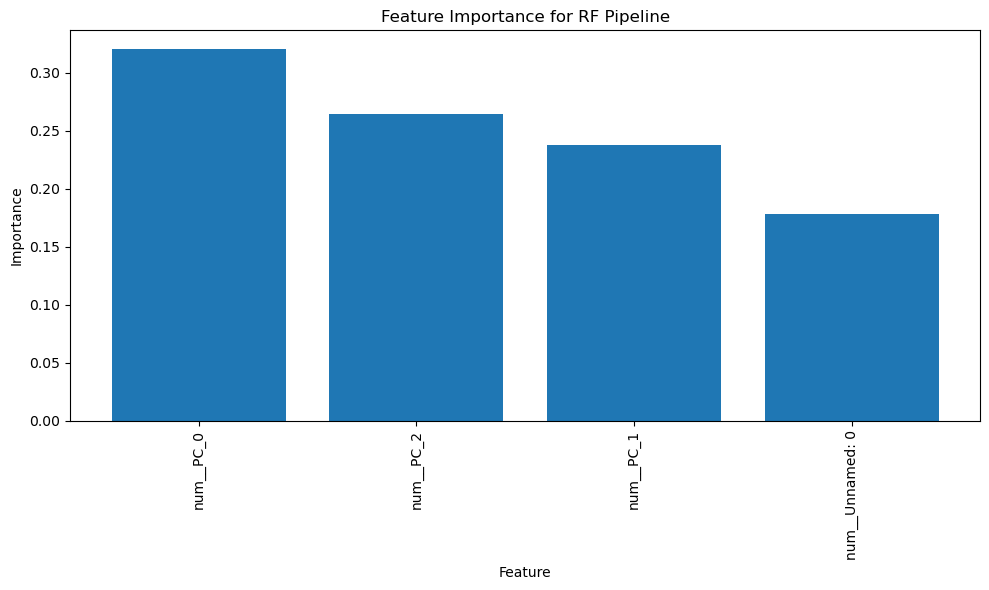

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(top_features_df['feature'], top_features_df['importance'])
ax.set_title("Feature Importance for RF Pipeline")
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
features=rf_pipe.named_steps['prep'].get_feature_names_out()

result = permutation_importance(
    rf_pipe,
    X_test,
    y_test,
    n_repeats=10, 
    random_state=42,
    n_jobs=-1     
)

In [ ]:
df_importance = pd.DataFrame(
    {'feature': features, 'importance_mean': result.importances_mean, 'importance_std': result.importances_std}
)
df_importance = df_importance.sort_values(by='importance_mean', ascending=False)
print(df_importance)

In [ ]:
plot_df = pd.concat([df_importance.head(10), df_importance.tail(10)])

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(plot_df['feature'], plot_df['importance_mean'], yerr=plot_df['importance_std'])
ax.set_title("Permutation Feature Importance on Test Data")
ax.set_xlabel("Feature")
ax.set_ylabel("Mean Accuracy Decrease")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
average_precision_score(y_test, rf_pipe.predict_proba(X_test)[:,1])

In [ ]:
result_2 = permutation_importance(
    rf_pipe,
    X_test,
    y_test,
    scoring='average_precision',
    n_repeats=10, 
    random_state=42,
    n_jobs=-1     
)

In [ ]:
df_importance_2 = pd.DataFrame(
    {'feature': features, 'importance_mean': result.importances_mean, 'importance_std': result.importances_std}
)
df_importance_2 = df_importance.sort_values(by='importance_mean', ascending=False)



plot_df_2 = pd.concat([df_importance_2.head(10), df_importance_2.tail(10)])

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(plot_df_2['feature'], plot_df['importance_mean'], yerr=plot_df_2['importance_std'])
ax.set_title("Permutation Feature Importance on Test Data")
ax.set_xlabel("Feature")
ax.set_ylabel("Mean AUPRC Decrease")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Ablation analysis 

In [ ]:
ablation_features=[item.removeprefix('num__') for item in df_importance_2['feature'].head(10).to_list()]
features_all=X_train.columns.to_list()

ablation_results={}
for feature in ablation_features:
    
    other_features = [f for f in features_all if f != feature]
    num_keep = X_train[other_features].select_dtypes(include=[np.number]).columns.tolist()
    cat_keep = X_train[other_features].select_dtypes(exclude=[np.number]).columns.tolist()
    
    prep_2 = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_keep),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_keep),
    ])

    rf_2 = RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        min_samples_leaf=2,
        max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    )

    rf_pipe_2 = Pipeline([("prep", prep_2), ("clf", rf_2)])
    
    rf_pipe_2.fit(X_train[other_features], y_train)
    
    
    ablated_scores = rf_pipe_2.predict_proba(X_test[other_features])[:, 1]
    ablated_auprc = average_precision_score(y_test, ablated_scores)
    
    
    ablation_results[feature] = ablated_auprc
    print(f"AUPRC without {feature}: {ablated_auprc:.4f}")    


In [ ]:
ablation_results

In [ ]:
df_ablation_results = pd.DataFrame.from_dict(ablation_results, orient='index')

df_ablation_results = df_ablation_results.reset_index()

df_ablation_results.columns = ['feature', 'AUPRC']
df_ablation_results

# sensitivity analysis

In [ ]:
full_score= average_precision_score(y_test, rf_pipe.predict_proba(X_test)[:,1])
scores = []
for leaf_amt in [1, 2, 5, 10]:
    rf_clone = clone(rf_pipe)                          
    rf_clone.set_params(clf__min_samples_leaf=leaf_amt)     
    rf_clone.fit(X_train, y_train)
    score = average_precision_score(y_test, rf_clone.predict_proba(X_test)[:, 1])
    scores.append({"min_samples_leaf": leaf_amt, "AUPRC": score})

sensitivity_df = pd.DataFrame(scores).sort_values("AUPRC", ascending=False)
sensitivity_df

## evaluate trade off between recall and precision

In [ ]:
score_y=rf_pipe.predict_proba(X_test)[:,1]

fig, ax = plt.subplots(figsize=(7, 5))
display = PrecisionRecallDisplay.from_predictions(y_test, score_y, ax=ax, name="RandomForest")

outcome_prevalence = y_test.sum() / len(y_test)
ax.plot([0, 1], [outcome_prevalence, outcome_prevalence], linestyle='--', label='baseline prevalence')


ax.set_title("Precision-Recall Curve")
ax.legend(loc="lower left")


plt.grid(True)
plt.show()

In [ ]:
y_pred = rf_pipe.predict(X_test)

y_proba = rf_pipe.predict_proba(X_test)[:, 1]

mistakes = np.where(y_test != y_pred)[0]


fps = mistakes[(y_test[mistakes] == 0) & (y_pred[mistakes] == 1)]
fns = mistakes[(y_test[mistakes] == 1) & (y_pred[mistakes] == 0)]

# # Show 3 FPs
# for i, idx in enumerate(fps[:3], 1):
#     print(f"\nFalse Positive {i}  (pos idx={idx}, df index={X_test.index[idx]})")
#     print(f"Actual: {y_test[idx]}  Pred: {y_pred[idx]}  Prob: {y_proba[idx]:.3f}")
#     print(X_test.iloc[idx].to_string())  # row by position

# # Show 3 FNs
# for i, idx in enumerate(fns[:3], 1):
#     print(f"\nFalse Negative {i}  (pos idx={idx}, df index={X_test.index[idx]})")
#     print(f"Actual: {y_test[idx]}  Pred: {y_pred[idx]}  Prob: {y_proba[idx]:.3f}")
#     print(X_test.iloc[idx].to_string())
print(fps) 
print(fns) 

In [ ]:
df_model = df_pca.copy()

In [ ]:
def part1():
    df_model['shortterm_death_or_deterioration'] = df['shortterm_death_or_deterioration'].values
    TARGET = 'shortterm_death_or_deterioration'
    X = df_model.drop(columns=[TARGET]).copy()
    y = df_model[TARGET].astype(int).values

    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.columns.difference(num_cols).tolist()

    preprocess = ColumnTransformer(
        transformers=[
            ("num", IterativeImputer(
                estimator=BayesianRidge(),
                max_iter=5,
                random_state=123
            ), num_cols),
            ("cat", OneHotEncoder(
                handle_unknown='ignore',
                min_frequency=0.01  
            ), cat_cols),
        ],
        remainder='drop',
        sparse_threshold=1.0 
    )

    pipe = ImbPipeline(steps=[
        ("prep", preprocess),
        ("smote", SMOTE(random_state=123, k_neighbors=3, sampling_strategy=0.30)),
        ("clf", LogisticRegression(
            max_iter=50,
            class_weight='balanced',
            n_jobs=-1,
            solver='saga'  
        ))
    ])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
    probs = cross_val_predict(pipe, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

    ths = np.linspace(0.02, 0.5, 49)
    best_t, best_f2 = 0.5, -1
    for t in ths:
        yhat = (probs >= t).astype(int)
        f2 = fbeta_score(y, yhat, beta=2, zero_division=0)
        if f2 > best_f2:
            best_f2, best_t = f2, t

    prec, rec, f1, _ = precision_recall_fscore_support(y, (probs >= best_t), average='binary', zero_division=0)
    print(f"Best threshold={best_t:.2f} | P={prec:.3f} R={rec:.3f} F1={f1:.3f} F2={best_f2:.3f} | AUPRC={average_precision_score(y, probs):.3f}")

    pipe.fit(X, y)
    #Best threshold=0.38 | P=0.072 R=1.000 F1=0.134 F2=0.279 | AUPRC=0.154
    return None 

do1 = part1()
print(do1)

In [ ]:
def part2():
    print('Starting model')
    df_model['shortterm_death_or_deterioration'] = df['shortterm_death_or_deterioration'].values
    TARGET = "shortterm_death_or_deterioration"
    X = df_model.drop(columns=[TARGET])
    y = df_model[TARGET].astype(int).values

    num = X.select_dtypes(include=[np.number]).columns
    cat = X.columns.difference(num)

    prep = ColumnTransformer([
        ("num", SimpleImputer(strategy="median"), num),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                        ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat),
    ])

    pipe = Pipeline([("prep", prep),
                    ("clf", LogisticRegression(solver="saga",
                                                penalty="elasticnet",
                                                class_weight="balanced",
                                                max_iter=5000, n_jobs=-1,
                                                random_state=42))])

    param_grid = {
        "clf__C": [0.1, 1.0, 10.0],
        "clf__l1_ratio": [0.0, 0.5, 1.0],  # 0=L2, 1=L1
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    gs = GridSearchCV(pipe, param_grid, cv=skf,
                    scoring="average_precision", n_jobs=-1, refit=True)
    gs.fit(X, y)
    print('fitting model')
    i = gs.best_index_
    print(f"Best AUPRC (CV mean±SD): {gs.cv_results_['mean_test_score'][i]:.3f} ± {gs.cv_results_['std_test_score'][i]:.3f}")
    print("Best params:", gs.best_params_)

    '''
    fitting model
    Best AUPRC (CV mean±SD): 0.168 ± 0.008
    Best params: {'clf__C': 0.1, 'clf__l1_ratio': 1.0}

    zach
    Best AUPRC (CV mean±SD): 0.414 ± 0.015
    Best params: {'clf__C': 10.0, 'clf__l1_ratio': 0.5}
    '''
    return None

do2 = part2()
print(do2)

In [ ]:
def part3():
    print('Starting model')
    df_model['shortterm_death_or_deterioration'] = df['shortterm_death_or_deterioration'].values
     
    TARGET = "shortterm_death_or_deterioration"
    X = df_model.drop(columns=[TARGET])
    y = df_model[TARGET].astype(int).values
    num = X.select_dtypes(include=[np.number]).columns
    cat = X.columns.difference(num)

    svm_prep = ColumnTransformer([
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                        ("sc", StandardScaler())]), num),
    ], remainder="drop")

    svm_pipe = Pipeline([("prep", svm_prep),
                        ("clf", SVC(kernel="rbf",
                                    class_weight="balanced",
                                    probability=False,  
                                    random_state=42))])

    svm_grid = {
        "clf__C": [1.0, 10.0],
        "clf__gamma": ['scale', 0.1],
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    gs_svm = RandomizedSearchCV(svm_pipe, svm_grid, n_iter=20, cv=skf,
                        scoring="average_precision", n_jobs=-1, refit=True)
    gs_svm.fit(X, y)

    j = gs_svm.best_index_
    print(f"SVM AUPRC (CV mean±SD): {gs_svm.cv_results_['mean_test_score'][j]:.3f} ± {gs_svm.cv_results_['std_test_score'][j]:.3f}")
    print("Best params:", gs_svm.best_params_)

    '''
    SVM AUPRC (CV mean±SD): 0.154 ± 0.006
    Best params: {'clf__gamma': 0.1, 'clf__C': 1.0}

    '''
    return None 

do3 = part3()
print(do3)